In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import pandas_datareader
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, RepeatVector
from keras.optimizers import Adam
from keras.losses import MeanSquaredError

# warnings.filterwarnings("ignore")
sns.set_theme (style="darkgrid")
%matplotlib inline

In [ ]:
crypto = "SAND-USD"
df = yf.download(crypto, start="2021-01-01", end="2022-08-01")

[*********************100%%**********************]  1 of 1 completed


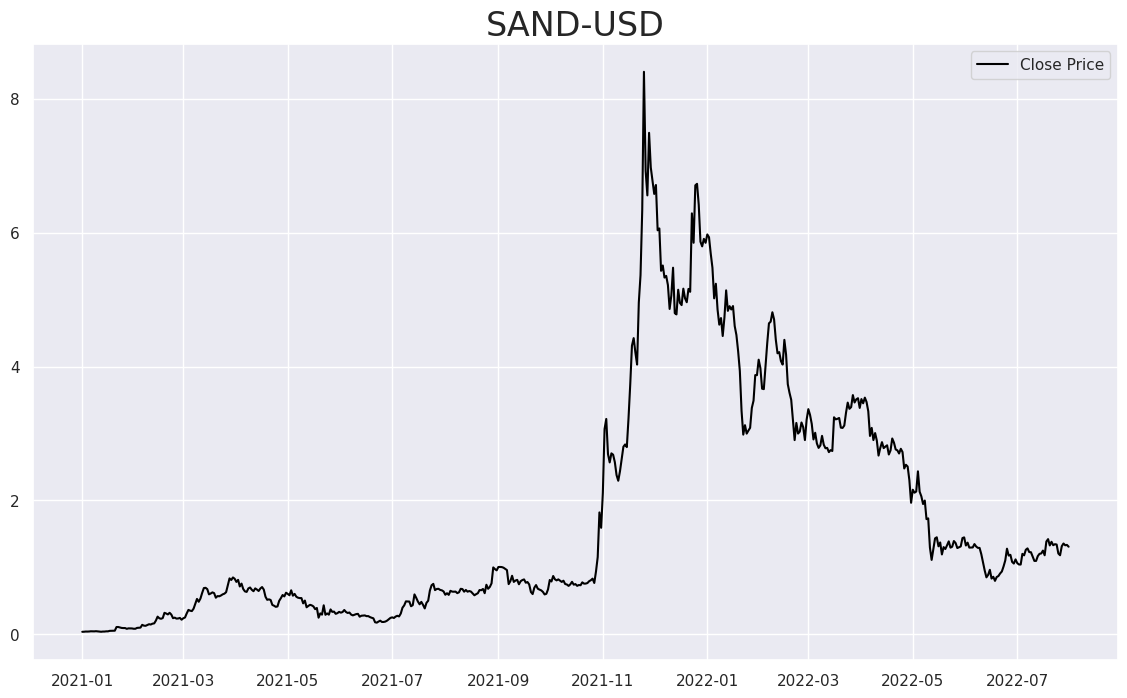

In [ ]:
plt.figure(figsize=(14,8))
plt.plot(df["Close"], color="black", label="Close Price")
plt.legend()
plt.title(crypto, size=24)
plt.show()

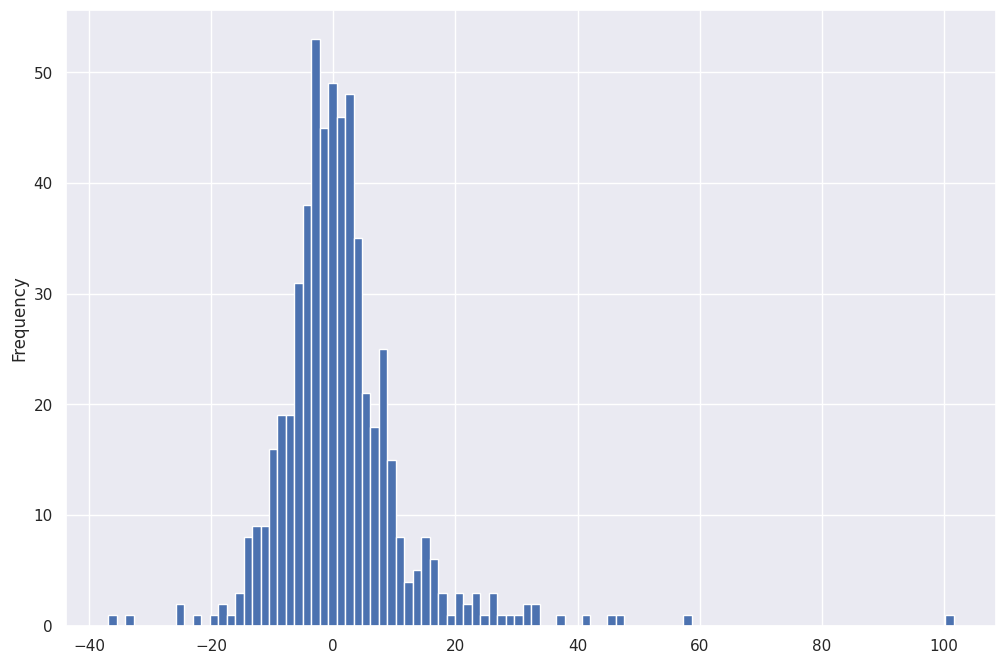

In [ ]:
df["Lag"] = df["Close"].shift(periods=1)
df["Diff"] = df["Close"].sub(df["Lag"])
df["Return"] = ((df["Close"].div(df["Lag"])).sub(1)).mul(100)
df = df[["Close", "Return"]]
retn = df["Return"]
retn = retn.dropna()
retn.plot(kind="hist", figsize=(12,8), bins=100)
plt.show()

<Figure size 1100x700 with 0 Axes>

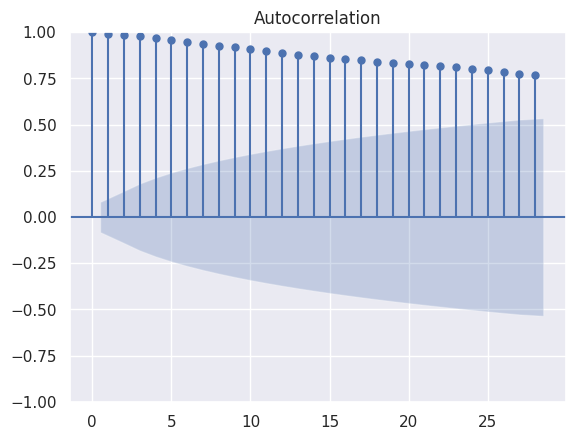

In [ ]:
plt.figure(figsize=(11, 7))
plot_acf(df["Close"])
plt.show()

<Figure size 1100x700 with 0 Axes>

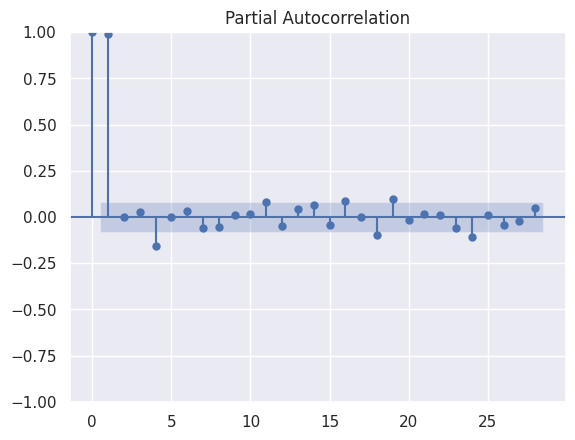

In [ ]:
plt.figure(figsize=(11, 7))
plot_pacf(df["Close"])
plt.show()

In [ ]:
scaler = StandardScaler()
scaled = scaler.fit_transform(df["Close"].values.reshape(-1,1))
df["Scaled Values"] = scaled
df = df[["Close", "Scaled Values"]]

<ipython-input-8-e3835abf88c9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Scaled Values"] = scaled


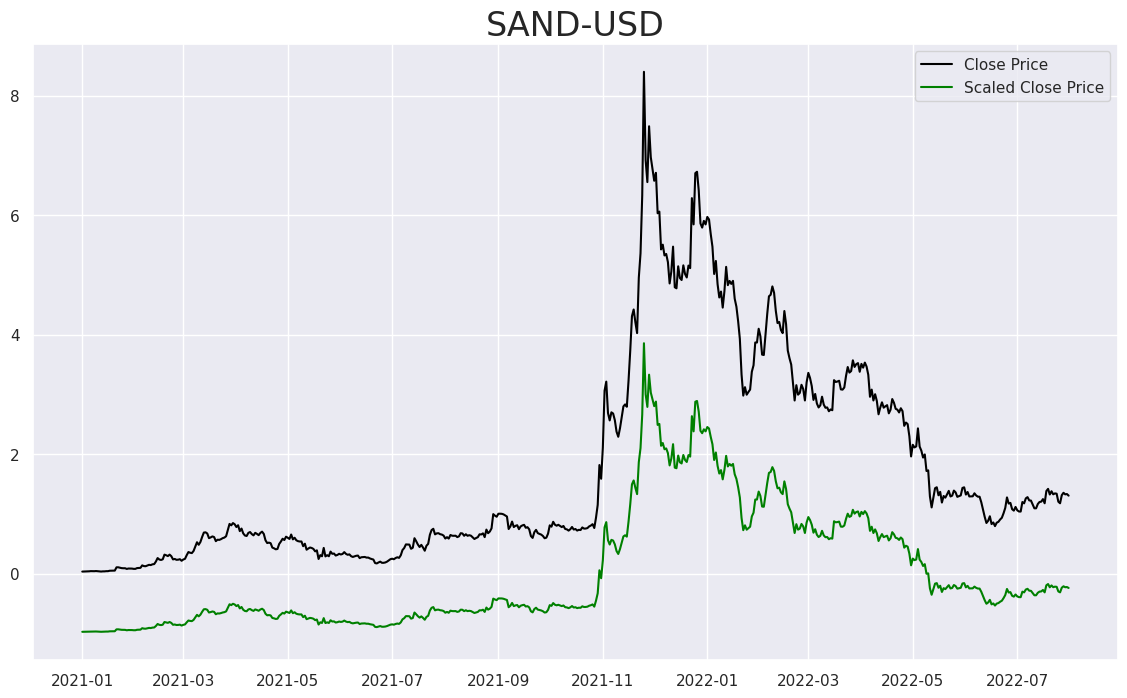

In [ ]:
plt.figure(figsize=(14,8))
plt.plot(df["Close"], color="black", label="Close Price")
plt.plot(df["Scaled Values"], color="green", label="Scaled Close Price")
plt.legend()
plt.title(crypto, size=24)
plt.show()

In [ ]:
crypto = "SAND-USD"
lstm_pred = []
lr_pred = []
rf_pred = []
poly = PolynomialFeatures(degree=2)
linearmodel = LinearRegression()
rfmodel = RandomForestRegressor(n_estimators=25, min_samples_split=4, oob_score= True)
lstm_model = Sequential()
lstm_model.add(LSTM(units=60, input_shape=(2,1)))
lstm_model.add(Dropout(0.1))
lstm_model.add(RepeatVector(1))
lstm_model.add(LSTM(units=30, return_sequences=True))
lstm_model.add(Dense(units=15))
lstm_model.add(Dense(units=7))
lstm_model.add(Dropout(0.1))
lstm_model.add(Dense(units=1))
lstm_model.compile(optimizer=Adam(), loss=MeanSquaredError())

In [ ]:
def start_algorithm(start_date, end_date, iterate=False):
    df = get_data(start_date, end_date)
    x_lr, y_lr = preprocess(df, algo="lr")
    x_rf, y_rf = preprocess(df, algo="rf")
    x_lstm, y_lstm = preprocess(df, algo="lstm")
    if iterate == False:
        pred_lr = fit_lr(x_lr, y_lr)
        pred_rf = fit_rf(x_rf, y_rf)
        pred_lstm = fit_lstm(x_lstm, y_lstm)
    elif iterate == True:
        pred_lr = fit_lr(x_lr, y_lr, refit=True)
        pred_rf = fit_rf(x_rf, y_rf, refit=True)
        pred_lstm = fit_lstm(x_lstm, y_lstm, refit=True)
    token, ans = give_token(y=y_rf[-1], rf=pred_rf, lr=pred_lr, lstm=pred_lstm)
    return token, ans

In [ ]:
def get_data(start_date, end_date):
    return pandas_datareader.DataReader(crypto, 'yahoo', start=start_date, end=end_date)

In [ ]:
start_date = datetime.datetime(2022, 1, 2)
end_date = datetime.datetime(2022, 1, 21)
get_data(start_date, end_date)

In [ ]:
def preprocess(df, algo):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df["Close"].values.reshape(-1,1))
    df["Scaled Values"] = scaled
    df = df[["Close", "Scaled Values"]]
    if algo != "lstm":
        df["Lag 1"] = df["Scaled Values"].shift(periods=1)
        df["Lag 2"] = df["Scaled Values"].shift(periods=2)
        df.interpolate(axis=1, inplace=True)
        x1 = df["Lag 1"].to_numpy().reshape(-1,1)
        x2 = df["Lag 2"].to_numpy().reshape(-1,1)
        x = np.concatenate((x1,x2), axis=1)
        if algo == "lr":
            y = df["Scaled Values"].to_numpy().reshape(-1,1)
        elif algo == "rf":
            y = df["Scaled Values"].to_numpy()
    else:
        timestep = 2
        x_temp = []
        y_temp = []
        for i in range(timestep, len(df)):
            x_temp.append(df["Scaled Values"].iloc[i-timestep:i])
            y_temp.append(df["Scaled Values"].iloc[i])
            tempx, y = np.array(x_temp), np.array(y_temp)
            x = tempx.reshape(tempx.shape[0], tempx.shape[1],1)
    return x, y

In [ ]:
def fit_lr(x, y, refit=False, first=False):
    px = poly.fit_transform(x)
    if refit == False:
        linearmodel.fit(px[:-1], y[:-1])
    else:
        linearmodel.fit(px, y)
    ans = linearmodel.predict(np.array([px[-1]]))
    if first == False:
        lr_pred.append(ans[0][0])
    return ans[0][0]

In [ ]:
def fit_rf(x, y, refit=False, first=False):
    if refit == False:
        rfmodel.fit(x[:-1], y[:-1])
    else:
        rfmodel.fit(x, y)
    ans = rfmodel.predict(np.array([x[-1]]))
    if first == False:
        rf_pred.append(ans[0])
    return ans[0]

In [ ]:
def fit_lstm(x, y, refit=False, first=False):
    if refit == False:
        lstm_model.fit(x[:-1], y[:-1], batch_size=12, epochs=18, verbose=0)
    else:
        lstm_model.fit(x, y, batch_size=12, epochs=18, verbose=0)
    ans = lstm_model.predict(np.array([x[-1]]), verbose=0)
    if first == False:
        lstm_pred.append(ans[0][0][0])
    return ans[0][0][0]

In [ ]:
def give_token(y, rf, lr, lstm):
    if abs(y-rf) < abs(y-lr) and abs(y-rf) < abs (y-lstm):
        return "Random Forest", rf
    elif abs(y-lr) < abs(y-rf) and abs(y-lr) < abs(y-lstm):
        return "Polynomial Regression", lr
    elif abs(y-lstm) < abs(y-lr) and abs(y-lstm) < abs(y-rf):
        return "LSTM", lstm

In [ ]:
def make_prediction (token, start_date, end_date):
    df = get_data(start_date, end_date)
    if token == "lr":
        x, y = preprocess(df, algo=token)
        answer = fit_lr(x, y, refit=True, first=True)
        return answer
    elif token == "rf":
        x, y = preprocess(df, algo=token)
        answer = fit_rf(x, y, refit=True, first=True)
        return answer
    elif token == "lstm":
        x, y = preprocess(df, algo="lstm")
        answer = fit_lstm(x, y, refit=True, first=True)
        return answer

In [ ]:
token = ""
start_date = datetime.datetime(2022, 1, 2)
end_date = datetime.datetime(2022, 1, 21)
flag = False
prediction = 0
pred_list = []
days = []
print(start_algorithm(start_date, end_date))
# while(end_date != datetime.datetime(2022, 8, 31)):
#     if token == "":
#         token, _ = start_algorithm(start_date, end_date)
#         print(f"Initial token given to {token} for {end_date.date()}")
#     else:
#         if flag == False:
#             start_date += datetime.timedelta(days=1)
#             prediction = make_prediction (token, start_date, end_date)
#             pred_list.append(prediction)
#             days.append(end_date)
#             start_date += datetime.timedelta(days=1)
#             end_date += datetime.timedelta(days=1)
#             token, prediction = start_algorithm(start_date, end_date, iterate=True)
#             pred_list.append(prediction)
#             days.append(end_date)
#             flag = True
#             print(f"{token} predicts for {end_date.date()}")
#         else:
#             start_date += datetime.timedelta(days=1)
#             end_date += datetime.timedelta(days=1)
#             token, prediction = start_algorithm(start_date, end_date, iterate=True)
#             pred_list.append(prediction)
#             days.append(end_date)
#             print(f"{token} predicts for {end_date.date()}")

In [ ]:
pred_list = np.array(pred_list)
days = np.array(days)
lstm_pred = np.array(lstm_pred)
lr_pred = np.array(lr_pred)
rf_pred = np.array(rf_pred)

In [ ]:
df = get_data(datetime.datetime(2022, 1, 22), datetime.datetime(2022, 8, 31))
x, y = preprocess(df, algo="rf")

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(days, rf_pred)
plt.plot(days, lr_pred)
plt.plot(days, lstm_pred)
plt.plot(days, y)
plt.xticks(rotation=45)
plt.legend(["Random Forest", "Polynomial Regression", "LSTM", "Actual Price"])
plt.show()

In [ ]:
error_lr = abs(y-lr_pred)
error_rf = abs(y-rf_pred)
error_lstm = abs(y-lstm_pred)

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(days, error_rf)
plt.plot(days, error_lr)
plt.plot(days, error_lstm)
plt.legend(["Random Forest", "Polynomial Regression", "LSTM"])
plt.show()